# How was it created?

## Problem statement

Reference: [Self-Organizing Map (Kohonen)](https://www.wikiwand.com/en/articles/Self-organizing_map)

## Table of Contents 

*NB: Generated a posteriori*


I. CORE SOM COMPONENTS

   - I.1 Weight Grid Initialization
   - I.2 Distance Metrics
   - I.3 BMU (Best Matching Unit)
   - I.4 Neighborhood Function
   - I.5 Weight Update Rule

II. EXTENDED TRAINING COMPONENTS

   - II.1 A 2D Toy Dataset
   - II.2 U-Matrix
   - II.3 Naive Training Loop
   - II.4 Quantization Error (QE)
   - II.5 Topographic Error (TE)
   - II.6 LR and σ Schedulers
   - II.7 Advanced Training Loop with Schedulers
   - II.8 Revised Plan

III. WEIGHTS INITIALIZATION METHODS

   - III.1 Random Initialization
   - III.2 PCA Initialization

IV. ADDITIONAL VISUALIZATIONS

V. REFACTORING

   - V.1 Class Implementation
   - V.2 README.md

**AI Prompt**

I want to create an Python package implementing a Self Organizing Map. Several Python packages already exist but I would prefer creating it from scratch to be sure to understand every single piece. 

The SOM implementation will be flexible and accept different distance metrics, learning rate and gaussian radius schedulers and assess SOM's quality using relevant metrics.

I want to comply with Polya's **"How to solve it framework"**.

I want also to make sure it uses `numpy` vectorization everywhere possible and use `fastcore`.

Refactoring as `class` should come at the end.

:::{.callout-tip}

**AI Response** 

I'll help you create a Self-Organizing Map (SOM) implementation from scratch. Let's follow Polya's framework step by step.

1. First, let's understand the problem:
   - Can you tell me your current familiarity with SOMs and what specific aspects you want to focus on?
   - Are you comfortable with numpy vectorization?
   - Do you have experience with fastcore?

This will help me tailor the guidance to your needs and ensure we build on your existing knowledge.

Also, before we proceed, could you outline which distance metrics and quality assessment measures you're particularly interested in implementing? This will help us plan the architecture effectively.
:::

**AI Prompt**

Let me try reformulating the SOM's approach and tell me if my understanding is correct.

We have a grid of (random - but could be informed by data itself) weights (same dimension of the input).

For each sample of our training set, we want to find the weight most similar to the input (bmu - best matching unit in SOM's jargon).

Once found we define a neighorhood function that essentially equal to 1 at the grid index of the bmu and decays/vanishes as further away from the bmu, as parametrized by a gaussian function with parameter sigma (to define a notion of "locality").

Then the objective is to "pull" all weights toward this individual input but proportionaly to this neighborhood function.
It means that we take the difference between the given input and the weights, and update the weights according to those differences and the neighborhood function.

A learning rate parameter also allow to specifify how quickly we want to update the weights for each sample.

What do you think? Did I capture the key concepts?

:::{.callout-tip}

**AI Response** 


Yes, that's an excellent and accurate description of the SOM algorithm! Let me highlight the key components you've identified:

1. Grid of weights (prototype vectors)
   - Initialize randomly (or with PCA/other informed methods)
   - Same dimensionality as input data

2. Best Matching Unit (BMU)
   - For each input, find closest weight vector
   - Requires distance metric (commonly Euclidean)

3. Neighborhood function
   - Gaussian decay from BMU location
   - Controlled by sigma parameter (radius)
   - Defines "influence zone" on grid

4. Weight update rule
   - Pull weights towards input
   - Strength determined by:
     * Learning rate (overall step size)
     * Neighborhood function (locality-based influence)

Would you like to start breaking this down into smaller implementation steps? We could begin by focusing on one of these components. Which part would you like to tackle first?
:::

# Devising plan

**AI Prompt**


Ok let's devise a plan that I can use to further monitor my progress along my implementation.

:::{.callout-tip}

**AI Response** 


Following Polya's framework, let's create a structured plan. Here's a suggested breakdown - please let me know if you'd like to modify any part:

1. Core SOM Components
   - Initialize weight grid
   - Implement distance metrics (Euclidean first, others later)
   - Find BMU function
   - Create neighborhood function
   - Implement weight update rule

2. Training Loop
   - Single sample update
   - Full epoch processing
   - Learning rate scheduling
   - Radius (sigma) scheduling

3. Quality Metrics
   - Quantization error
   - Topographic error
   - Other quality measures

4. Utilities & Visualization
   - Grid visualization
   - U-Matrix
   - Component planes

5. Refactoring
   - Create class structure
   - Add flexibility for different metrics/schedulers
   - Documentation

Would you like to refine this plan? We can discuss what specific functionality you want in each component before starting the implementation.
:::

**AI Prompt**


It sounds perfect! Let's carry out the plan.

:::{.callout-tip}

**AI Response** 


Great! Let's start with the first component: initializing the weight grid. 

Before we write any code, we need to decide:
1. What parameters will we need for initialization?
   - Grid dimensions (e.g., n_rows, n_cols)
   - Input data dimension
   - Initialization method (random, PCA-based, etc.)

Would you like to start implementing the weight grid initialization? What initialization method would you prefer to begin with?

Let me know your preferences, and we can discuss how to make it efficient using numpy vectorization.
:::

# Carrying out the plan

## I. CORE SOM COMPONENTS

### I.1 Weight grid

In [ ]:
import numpy as np
grid_sz = (3,3)
ws = np.random.randn(*grid_sz)
ws.shape, ws
ws.shape, ws

((3, 3),
 array([[-1.361616  , -0.47049376, -0.95493151],
        [ 1.41949963, -0.01988135, -1.88250715],
        [-0.41864399, -1.87207718, -0.51610482]]))

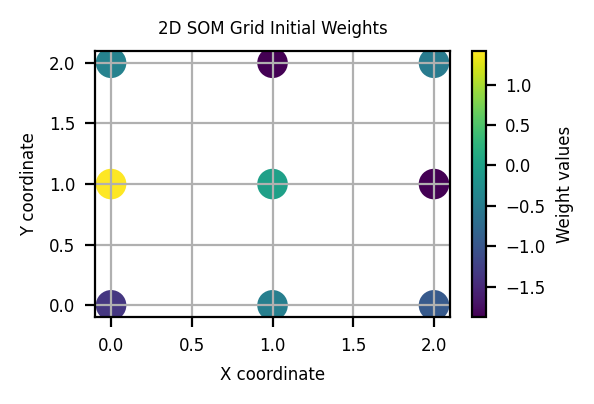

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 2))  # Compact figure size
plt.rcParams.update({'font.size': 6})  # Base font size

# Create meshgrid for plotting
x, y = np.meshgrid(range(grid_sz[0]), range(grid_sz[1]))

plt.scatter(x, y, c=ws, s=100, cmap='viridis')  
plt.colorbar(label='Weight values')

plt.grid(True)
plt.title('2D SOM Grid Initial Weights', fontsize=6)
plt.xlabel('X coordinate', fontsize=6)
plt.ylabel('Y coordinate', fontsize=6)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

### I.2 Distance

In [ ]:
ws = np.random.randn(3,3,200)
ws.shape

(3, 3, 200)

In [ ]:
X = np.random.randn(100,200)
X.shape

(100, 200)

In [ ]:
X[0].shape

(200,)

**AI Prompt**


Each node of the grid (here 3x3) has a weight of 200 dimensions in our toy example. How to take the euclidean distance between each weight and a 200-dimensional input?

:::{.callout-tip}

**AI Response** 


Let's think about this vectorized approach:

1. For Euclidean distance, we need √(Σ(x-w)²) between:
   - One input vector (1, 200)
   - All weight vectors (3, 3, 200)

We have two main vectorized approaches we could use:
1. Using numpy broadcasting and np.sum
2. Using scipy's cdist (which handles this specific case)

Would you like to try implementing one of these approaches? I can guide you through the numpy broadcasting solution first if you'd like, or we can discuss the trade-offs between the two approaches.

Which would you prefer to explore first?
:::

`Numpy` will broadcast the 1-dimensioal input vector of shape `(200,)` to `(3,3,200)` to align it to the weights shape.
We want the distance between each unit (200-dimensional in our toy example) and the given input.
There are two ways to do so. Either using native `numpy` or ...

In [ ]:
# Element-wise distance between each `(200,)` node/weights and the input.
(X[0]-ws).shape

(3, 3, 200)

In [ ]:
# Now we take the root square of the square distance element-wise and take their sum along the last dimension (200)
np.sqrt(np.sum((X[0]-ws)**2, axis=-1))

array([[17.91644487, 19.40803926, 18.10014622],
       [18.92468523, 19.64872772, 21.76170238],
       [21.98737528, 20.59933278, 19.29730677]])

In [ ]:
# We can do it also using numpy dedicated method
np.linalg.norm(ws-X[0], axis=-1)

array([[17.91644487, 19.40803926, 18.10014622],
       [18.92468523, 19.64872772, 21.76170238],
       [21.98737528, 20.59933278, 19.29730677]])

In [ ]:
# This is to be injected into the final class for further flexibility
dist_fn = lambda x, ws: np.linalg.norm(ws-x, axis=-1)
dist_fn(X[0], ws)

array([[17.91644487, 19.40803926, 18.10014622],
       [18.92468523, 19.64872772, 21.76170238],
       [21.98737528, 20.59933278, 19.29730677]])

### I.3 BMU (Best Matching Unit)

**AI Prompt**


I'd like to find the closest unit/node from a given input and want to return its index.

:::{.callout-tip}

**AI Response** 


To find the BMU index, we need to:
1. Get the distances (which we already calculated)
2. Find the index of the minimum distance in our 2D grid

We can use `np.argmin()`, but since we have a 2D grid, we'll need to consider how to handle the indices. Would you like to try implementing this yourself, or would you like me to suggest an approach?

A key consideration is whether you want:
- A flat index (single number)
- Grid coordinates (row, col)

Which format would be more useful for your implementation?
:::

**AI Prompt**


I want to find the grid coordinates but `np.argmin()` seems to work only for flatten arrays.

:::{.callout-tip}

**AI Response** 


Ah yes! For 2D coordinates, we can use `np.unravel_index()` together with `np.argmin()`. This combination will:

1. `np.argmin()` finds the index in the flattened array
2. `np.unravel_index()` converts this flat index back to grid coordinates

Would you like to try implementing this yourself using these functions? I can provide more details about how `np.unravel_index()` works if needed.
:::

In [ ]:
np.random.seed(1)
ws = np.random.randn(2,2,1)
x = np.array(0.5)
d = dist_fn(X[0], ws)
print(x, '\n', d)
np.argmin(d)

0.5 
 [[27.38521073 16.09891829]
 [15.54144978 20.16819721]]


2

In [ ]:
np.unravel_index(2,shape=ws.shape[:2])

(1, 0)

So, finding the grid index of the smallest distance is as simple as taking the `np.argmin` (internally flattening the array) and then using `np.unravel_index` with grid shape specified:

In [ ]:
def bmu_coords(dists, sz):
    return np.unravel_index(np.argmin(dists), sz)

bmu_coords(dist_fn(X[0], ws), ws.shape[:2])

(1, 0)

### I.4 Create neighborhood function

**AI Prompt**


Let me try to recap and reformulate the role of the neighborhood function with my own words. The weights update will be carried out according to the following logic:
1. we first get the distance between a given input and all units/nodes
2. the closest unit is called the bmu
3. Each unit will be then updated as a function of:
    - its distance from the given input
    - but also of its "decayed" distance of its grid index from the bmu
    - by "decayed" we mean that using a gaussian function parametrized by a "radius of influence" or a "degree of locality", we update the units close from the bmu more than the distant one.

Hence the neighborhood function, should return for a given node a coefficient that will be used to further weigh the weights update. Last, it is important to note that this update will be further parametrized by a learning rate `lr`.

Is my thinking correct?

:::{.callout-tip}

**AI Response** 


Yes, your understanding is excellent! You've captured all the key aspects of the neighborhood function and its role in weight updates. Let me confirm each point:

1. ✓ Calculate distances & find BMU
2. ✓ For each unit, weight update depends on:
   - Distance from input (the error term)
   - Distance from BMU on the grid (neighborhood influence)
   - Gaussian decay based on grid distance (controlled by radius σ)
3. ✓ Final update magnitude determined by:
   - Neighborhood coefficient (from gaussian)
   - Learning rate (lr)

Would you like to start implementing the neighborhood function? We'll need to:
1. Calculate grid distances from BMU to all nodes
2. Apply gaussian decay to these distances

Which part would you like to tackle first?
:::

In [ ]:
ws = np.random.randn(3,4,1)
bmu_idx = (2,2)

In [ ]:
# 1 row, 3 cols
a = np.array([
    [1,2,3,4]
    ])
a.shape

(1, 4)

In [ ]:
# 3 rows, 1 col
b = np.array([
    [10],
    [20],
    [30]
    ])
b.shape

(3, 1)

In [ ]:
# (3, 1) + (1, 4) -> (3,4)
# or (1, 4) + (3, 1) -> (3, 4)

In [ ]:
a + b

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [31, 32, 33, 34]])

In [ ]:
b + a

array([[11, 12, 13, 14],
       [21, 22, 23, 24],
       [31, 32, 33, 34]])

In [ ]:
bmu_idx

(2, 2)

**AI Prompt**


From the `(3,4)` shape I'd like to create two numpy arrays: one of shape (1,4) with the following values [0,1,2,3] (the rows idx) and one of shape (3,1) with the following values [0,1,2]. From those arrays, I then want to calculate the delta x and delta y from the bmu coordinates to eventually get a neighborhood function then I'd further weigh by a gaussian kernel. Can you guide me?

:::{.callout-tip}

**AI Response** 


I'll help you step by step:

1. First, let's create those two arrays using `np.arange()`:
```python
x_coords = np.arange(4).reshape(1, 4)  # [0,1,2,3] shape (1,4)
y_coords = np.arange(3).reshape(3, 1)  # [0,1,2] shape (3,1)
```

Would you like to try this first and then we can move on to calculating the deltas from the BMU coordinates? 

The next step would be subtracting the BMU's x and y coordinates from these arrays. Would you like to try that yourself, or would you like more guidance?
:::

**AI Prompt**


Isn't there a more straightforward to get those x and y coords directly from the shape (3,4) using a dedicated numpy method?

:::{.callout-tip}

**AI Response** 


Ah yes! You can use `np.meshgrid()` to directly generate coordinate arrays from the shape. This function is specifically designed for creating coordinate matrices. Would you like to explore how to use `np.meshgrid()` for this purpose?

Let me know if you want to try it yourself first, or if you'd like me to show you how it works with your (3,4) shape example.
:::

**AI Prompt**


I've heard about this method: `np.ogrid[0:grid_sz[0], 0:grid_sz[1]]` Don't you think it would be more convenient?

:::{.callout-tip}

**AI Response** 


Yes, absolutely! `np.ogrid` is a more concise and elegant solution for this case. It creates an "open mesh" which is exactly what we need - two arrays suitable for broadcasting, without actually storing the full mesh in memory. 

Would you like to try using `np.ogrid` to:
1. Create the coordinate arrays
2. Calculate the deltas from the BMU position

Which step would you like to tackle first?
:::

In [ ]:
x_coords, y_coords = np.ogrid[0:ws.shape[0], 0:ws.shape[1]]
x_coords, y_coords

(array([[0],
        [1],
        [2]]),
 array([[0, 1, 2, 3]]))

In [ ]:
bmu_idx, bmu_idx[0] - x_coords

((2, 2),
 array([[2],
        [1],
        [0]]))

In [ ]:
bmu_idx[1] - y_coords

array([[ 2,  1,  0, -1]])

In [ ]:
(bmu_idx[0] - x_coords)**2 + (bmu_idx[1] - y_coords)**2

array([[8, 5, 4, 5],
       [5, 2, 1, 2],
       [4, 1, 0, 1]])

In [ ]:
def grid_dist2(bmu_idx, grid_sz):
    rows_idx, cols_idx = np.ogrid[0:grid_sz[0], 0:grid_sz[1]]
    return (bmu_idx[0] - rows_idx)**2 + (bmu_idx[1] - cols_idx)**2

grid_dist2(bmu_idx, ws.shape[:2])

array([[8, 5, 4, 5],
       [5, 2, 1, 2],
       [4, 1, 0, 1]])

**AI Prompt**


I think that now suffices to pass this array to a Gaussian function to create our neighborhood function, don't you think?

:::{.callout-tip}

**AI Response** 


Yes, exactly! We can create a Gaussian decay function using `np.exp(-dist²/(2σ²))`, where:
- dist² is what we just calculated
- σ (sigma) is our radius parameter that controls the spread of the neighborhood

Would you like to try implementing this Gaussian function? We'll need to:
1. Take our squared distances
2. Apply the Gaussian formula with a sigma parameter

Would you like to try this yourself, or would you like some guidance on the implementation?
:::

In [ ]:
gaussian_fn = lambda dists, sigma: np.exp(-dists/(2*sigma**2))
gaussian_fn(grid_dist2(bmu_idx, ws.shape[:2]), 1)

array([[0.01831564, 0.082085  , 0.13533528, 0.082085  ],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944],
       [0.13533528, 0.60653066, 1.        , 0.60653066]])

In [ ]:
from functools import partial
def neighborhood_fn(dists, kernel_fn):
    return kernel_fn(dists)
    
dists = grid_dist2(bmu_idx, ws.shape[:2])
kernel_fn = partial(gaussian_fn, sigma=1)
neighborhood_fn(dists, kernel_fn)

array([[0.01831564, 0.082085  , 0.13533528, 0.082085  ],
       [0.082085  , 0.36787944, 0.60653066, 0.36787944],
       [0.13533528, 0.60653066, 1.        , 0.60653066]])

### I.5 Implement weight update rule

**AI Prompt**


Let me reformulate the weight update rule. Given an input, the SOM weights/nodes/units will be updated as follows:
1. compute the distance between the input and all weights/nodes/units, `d`
2. compute the distance from the bmu position from all other grids/weights position `d_grid``
3. `w_new = w + lr*d*neighborhood_fn(d_grid) where lr is the learning rate

In summary at every iteration (new sample), we pull all weights and their surroundings (as defined by the neighborhood function) toward the input (the bmu weights being the most affected).

Am I right?

:::{.callout-tip}

**AI Response** 


Yes, your understanding is perfect! Let me break down your correct formulation:

For each input sample:
1. ✓ Calculate distances between input and all weights
2. ✓ Find BMU (closest weight)
3. ✓ Calculate grid distances from BMU position
4. ✓ Apply neighborhood function to grid distances
5. ✓ Update weights using the formula:
   `w_new = w + lr * (input - w) * neighborhood_fn(d_grid)`

One small clarification to your formula: the `d` term should be `(input - w)`, representing the direction and magnitude of the update.

Would you like to try implementing this update rule? We can break it down into steps if you'd like.
:::


Let's do it step-by-step while checking shapes "compatibility" for numpy broadcasting.

In [ ]:
ws = np.random.randn(2,2,3)
x = np.array([0.5, 0.1, 0.2])
(x-ws).shape

(2, 2, 3)

In [ ]:
# Define kernel function with wanted parameter
kernel_fn = partial(gaussian_fn, sigma=1)
# Get bmu position
bmu_idx = bmu_coords(dist_fn(x, ws), ws.shape[:2])
# Compute neighborhood weights for each unit
nbh = neighborhood_fn(grid_dist2(bmu_idx, ws.shape[:2]), kernel_fn)
nbh.shape

(2, 2)

The neighborhood will weigh eacg node's update give its distance from the bmu and provided kernel functions. So we want an element-wised multiplication between this `2x2`array and the first two dimensions of the (x-ws) differences. Hence to be able to use numpy broadasting we have to add an additional trailing dimension to the neighborhood.

In [ ]:
nbh[..., np.newaxis].shape

(2, 2, 1)

In [ ]:
(nbh[..., np.newaxis] * (x-ws)).shape

(2, 2, 3)

We now have all components required to define the update function.

In [ ]:
lr = 1
ws = np.random.randn(2,2,3)
x = np.array(0.5)

d = dist_fn(x, ws)
bmu_idx = bmu_coords(d, ws.shape[:2])
d_grid = grid_dist2(bmu_idx, ws.shape[:2])
kernel_fn = partial(gaussian_fn, sigma=1)
nbh = neighborhood_fn(grid_dist2(bmu_idx, ws.shape[:2]), kernel_fn)

ws + lr * (nbh[..., np.newaxis] * (x-ws))

array([[[ 0.01460216,  0.51918831, -0.25327326],
        [ 0.14715498,  0.03288394, -0.02929718]],

       [[ 0.03915056,  0.2982822 , -0.13636204],
        [ 0.5       ,  0.5       ,  0.5       ]]])

In [ ]:
def update(x, ws, dist_fn, kernel_fn, lr=1):
    bmu_idx = bmu_coords(dist_fn(x, ws), ws.shape[:2])
    d_grid = grid_dist2(bmu_idx, ws.shape[:2])
    nbh = neighborhood_fn(grid_dist2(bmu_idx, ws.shape[:2]), kernel_fn)
    return ws + lr * nbh[..., np.newaxis] * (x-ws)

ws = np.random.randn(2,2,3)
x = np.array([0.5, 0.1, 0.2])
kernel_fn = partial(gaussian_fn, sigma=1)
update(x, ws, dist_fn, kernel_fn, lr=1)

array([[[ 0.06267652, -0.52430057, -0.39871823],
        [ 0.96919433,  0.08064436, -0.12933212]],

       [[ 0.37838472,  0.88703907,  0.168585  ],
        [ 0.5       ,  0.1       ,  0.2       ]]])

In [ ]:
ws = np.array([
    [[1], [2]], 
    [[3], [4]
    ]])
np.squeeze(ws) # squeeze the trailing dim for clearer printing

array([[1, 2],
       [3, 4]])

In [ ]:
x = np.array(3.8)
np.squeeze(update(x, ws, dist_fn, kernel_fn, lr=1))

array([[2.03006244, 3.09175519],
       [3.48522453, 3.8       ]])

Ok, we observe that the SOM's nodes are pulled toward the bmu accordingly. We have all core SOM compoenents, we can implement now the training loop.

### I.6 Revised plan

**AI Prompt**


I think that should be pretty straightforward to implement. We know how to update the SOM/weights for every single data point. It suffices to iterate over the training set multiple times (epochs) until we think this is enough right? 

Obviously it raises a couple of questions. First usually, the learning rate and for instance the gaussian kernel sigma are decayed during training. Second, after each epoch (one pass over the train set), we'd like to log some metrics (Quantization error and Topographic error). Also, I think that would be very useful if we could visualize how the SOM improves as we add new features like scheduled learning rate and gaussian kernel sigma. Hence, I'd like to implement a U-Matrix visualization in priority. So I think we have to slightly revised the initial plan (shown below) to take into account both decay, metrics and U-matrix now as it is interleaved with the training loop. Ideally, we should implement second the training loop but implement in this main step also U-Matrix visualization, ... so that we can see how the training loop, training loop + scheduler affect the training visually.

Initial plan:
Following Polya's framework, let's create a structured plan. Here's a suggested breakdown - please let me know if you'd like to modify any part:

1. Core SOM Components
    - Initialize weight grid (DONE)
    - Implement distance metrics (Euclidean first, others later) (DONE)
    - Find BMU function (DONE)
    - Create neighborhood function (DONE)
    - Implement weight update rule (DONE)

2. Training Loop
    - Single sample update (DONE)
    - Full epoch processing
    - Learning rate scheduling
    - Radius (sigma) scheduling

3. Quality Metrics
    - Quantization error
    - Topographic error
    - Other quality measures

4. Utilities & Visualization
    - Grid visualization
    - U-Matrix
    - Component planes

5. Refactoring
    - Create class structure
    - Add flexibility for different metrics/schedulers
    - Documentation

Please adjust the plan accordingly.

:::{.callout-tip}

**AI Response** 


You make excellent points! Yes, we should revise the plan to better integrate visualization and metrics with the training loop, since they're crucial for understanding how the SOM evolves. Here's a suggested revision:

1. Core SOM Components (DONE)
   - ✓ Initialize weight grid
   - ✓ Distance metrics
   - ✓ BMU function
   - ✓ Neighborhood function
   - ✓ Weight update rule

2. Extended Training Components
   - Training loop structure
   - U-Matrix visualization (moved up from 4)
   - Basic quality metrics (moved up from 3)
   - Learning rate scheduler
   - Radius scheduler
   - Training progress visualization

3. Additional Quality Metrics
   - Quantization error
   - Topographic error
   - Custom metrics interface

4. Additional Visualizations
   - Component planes
   - Custom visualization options

5. Refactoring
   - Class structure
   - Flexible interfaces
   - Documentation

Would you like to start with implementing the training loop along with U-Matrix visualization so you can see the SOM's evolution during training?
:::

## II. EXTENDED TRAINING COMPONENTS

Let's first implementing a training (fit) loop to see where and how scheduling should take place.

### II.1 A 2D toy dataset

In [ ]:
!pip3 install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
X, y = make_blobs(n_samples=1_000, centers=3, cluster_std=0.5, random_state=0)

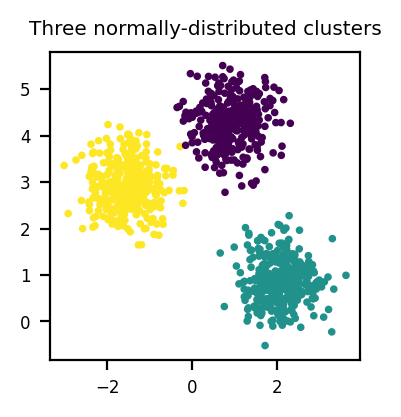

In [ ]:
plt.figure(figsize=(2,2))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=3)
plt.title("Three normally-distributed clusters")
plt.show()

In [ ]:
X.shape

(1000, 2)

In [ ]:
n_nodes = lambda n_samples: int(np.sqrt(5*np.sqrt(n_samples)))
n_nodes(200)

8

In [ ]:
n_samples = len(X)
grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
ws = np.random.randn(*grid_sz, X.shape[-1])
ws.shape

(12, 12, 2)

### II.2 U-Matrix

**AI Prompt**


I'd like to create a U-Matrix visualization. Correct me if I am wrong but my understanding is the following:
- for each unit/node, we compute the average or sum of the distances between the node and its neighbours (from 2 for the corners to 3 at the edges and 4 for the others)
- we then represent those aggregated "surrounding" distances in the grid
- it can be interpreted as follows (when bright is small distance and dark is large distance): a group of bright nodes surrounded by dark ones suggest a cluster 

Am I right?

:::{.callout-tip}

**AI Response** 


Yes, your understanding of the U-Matrix (Unified Distance Matrix) is correct! Let me confirm each point:

1. ✓ For each node:
   - Calculate distances to immediate neighbors
   - Can have 2 neighbors (corners)
   - Can have 3 neighbors (edges)
   - Can have 4 neighbors (interior nodes)

2. ✓ Visualization shows:
   - Average/sum of distances to neighbors
   - Usually displayed as a heatmap

3. ✓ Interpretation:
   - Bright regions = similar nodes = potential cluster
   - Dark regions = dissimilar nodes = potential boundaries
   - Dark "barriers" between bright regions suggest cluster boundaries

Would you like to implement this visualization? We'll need to:
1. Create a function to find neighbors for each node
2. Calculate distances between neighbors
3. Create the visualization

Which part would you like to tackle first?
:::

In [ ]:
# Test weights matrix (SOM)
x = np.array([
    [[1], [3], [1]],
    [[11], [4], [2]],
    [[7], [8], [5]]])

np.squeeze(x)

array([[ 1,  3,  1],
       [11,  4,  2],
       [ 7,  8,  5]])

I first attempted an approach using vectorization, padded and masked version of the weights. I am finding cluncky and much less readable than a more straightforward iteration throughout the weights.

In [ ]:
# For instance a right-padded version of test weights matrix
x_right = np.pad(x, ((0,0), (0,1), (0,0)), mode='edge')
d_right = np.linalg.norm(x_right[:,1:] - x_right[:,0:-1], axis=-1)
d_right

array([[2., 2., 0.],
       [7., 2., 0.],
       [1., 3., 0.]])

Below, an iterative approach:

In [ ]:
# Neighbors offsets
nbr_offsets = [
    (-1,-1), (-1,0), (-1,1),  # top-left, top, top-right
    (0,-1),          (0,1),   # left, right
    (1,-1),  (1,0),  (1,1)    # bottom-left, bottom, bottom-right
]

In [ ]:
n_rows, n_cols = 3,3
pos = (0,1)
_ws = []
ds = []
for dr,dc in nbr_offsets:
    r,c = pos
    nbr_r, nbr_c = r+dr, c+dc
    if (nbr_r>=0 and nbr_r<n_rows) and (nbr_c>=0 and nbr_c<n_cols):
        w = 1/np.sqrt(dr**2 + dc**2)
        _ws.append(w)
        d = np.linalg.norm(x[r, c] - x[nbr_r, nbr_c], axis=-1)
        ds.append(d)
        print(f'distance between: {r,c} and {nbr_r, nbr_c}: {d} with weight: {w:.2f}')

np.average(ds, weights=_ws)

distance between: (0, 1) and (0, 0): 2.0 with weight: 1.00
distance between: (0, 1) and (0, 2): 2.0 with weight: 1.00
distance between: (0, 1) and (1, 0): 8.0 with weight: 0.71
distance between: (0, 1) and (1, 1): 1.0 with weight: 1.00
distance between: (0, 1) and (1, 2): 1.0 with weight: 0.71


2.5744021828816153

In [ ]:
def is_in_bounds(row_idx, col_idx, ws):
    n_rows, n_cols = ws.shape[:2]
    return  (row_idx>=0 and row_idx<n_rows) and (col_idx>=0 and col_idx<n_cols) 

print(is_in_bounds(0,0,x))
print(is_in_bounds(-1,0,x))
print(is_in_bounds(4,0,x))

True
False
False


In [ ]:
def nbr_dist(pos, ws, dist_fn, nbr_offsets=nbr_offsets):
    weights = []
    ds = []
    for dr,dc in nbr_offsets:
        r,c = pos
        nbr_r, nbr_c = r+dr, c+dc
        if is_in_bounds(nbr_r, nbr_c, ws):
            weights.append(1/np.sqrt(dr**2 + dc**2))
            d = dist_fn(ws[r, c] - ws[nbr_r, nbr_c], axis=-1)
            ds.append(d)

    return np.average(ds, weights=weights)

pos = (0,1)
nbr_dist(pos, x, np.linalg.norm)

2.5744021828816153

In [ ]:
np.squeeze(x)

array([[ 1,  3,  1],
       [11,  4,  2],
       [ 7,  8,  5]])

In [ ]:
u_matrix = np.zeros(x.shape[:2])
for i, j in np.ndindex(x.shape[:2]):
    u_matrix[i,j] = nbr_dist((i,j), x, np.linalg.norm)

u_matrix

array([[5.21638838, 2.57440218, 1.89180581],
       [6.51943414, 3.08578644, 2.48056586],
       [2.63060194, 3.25402494, 2.47759225]])

In [ ]:
def calculate_umatrix(weights, dist_fn=np.linalg.norm):
    u_matrix = np.zeros(weights.shape[:2])
    for i, j in np.ndindex(weights.shape[:2]):
        u_matrix[i,j] = nbr_dist((i,j), weights, dist_fn)
    return u_matrix

calculate_umatrix(x)

array([[5.21638838, 2.57440218, 1.89180581],
       [6.51943414, 3.08578644, 2.48056586],
       [2.63060194, 3.25402494, 2.47759225]])

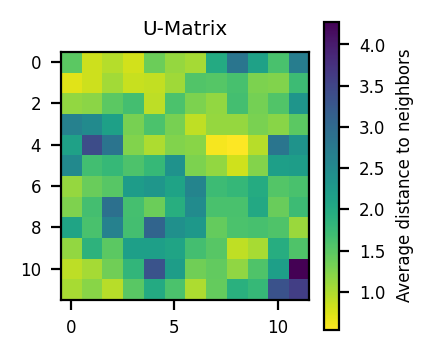

In [ ]:
def plot_umatrix(weights, cmap='viridis_r', figsize=(2,2)):
    umatrix = calculate_umatrix(weights)
    plt.figure(figsize=figsize)
    plt.imshow(umatrix, cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Average distance to neighbors')
    plt.title('U-Matrix')
    plt.show()

plot_umatrix(ws)

### II.3 Naive training loop

In [ ]:
from tqdm import trange, tqdm
n_epochs = 20
for epoch in tqdm(range(n_epochs)):
    X_ = np.random.permutation(X)
    for x in X:
        kernelf_fn = partial(gaussian_fn, sigma=1)
        ws = update(x, ws, dist_fn, kernel_fn, lr=0.1)


100%|##########| 20/20 [00:02<00:00,  7.54it/s]


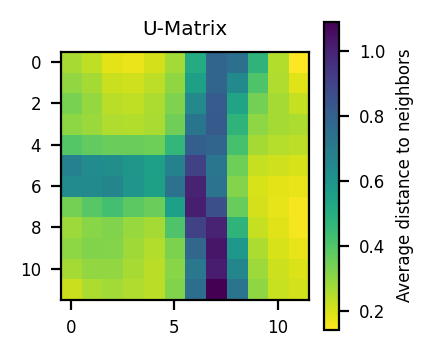

In [ ]:
plot_umatrix(ws)

**AI Prompt**

Great, we clearly see the 3 clusters captured. Now I'd like to implement some of the metrics: Quantization Error and Topographic Error so that to log it after every epoch ideally.

:::{.callout-tip}

**AI Response** 


Let's implement these two metrics:

1. Quantization Error (QE):
   - Average distance between each input vector and its BMU
   - Measures how well the map represents the input space

2. Topographic Error (TE):
   - Proportion of data vectors for which 1st and 2nd BMUs are not adjacent
   - Measures preservation of topology

Would you like to implement these metrics one at a time? We can start with the Quantization Error since it's simpler and uses components we already have (distance function and BMU finding).

Which metric would you prefer to tackle first?
:::


### II.4 Quantization Error (QE)

**AI Prompt**


Here is my understanding and plan to calculate QE (Quantization Error) For each sample of the training set we have to: 
- identify its bmu (we already have a function for this)
- calculate input/sample distance from its bmu (we have this already)
- take the mean of those distances

Actually when we search the bmu, we take the `argmin` of the distances between each node/unit and the input. Here, we don't need to search the bmu, taking the min of the distances would already solve our problem.

In summary, I think we already have all elements. What do you think?

:::{.callout-tip}

**AI Response** 


Yes, your understanding is perfect! You've made a very astute observation about reusing the distance calculation and just needing the minimum value rather than its position.

For each input x, we:
1. Calculate distances to all nodes (using our `dist_fn`)
2. Take the minimum distance (don't need `argmin`, just `min`)
3. Average these minimum distances across all inputs

Would you like to try implementing this as a function? We can use numpy's vectorized operations to make it efficient. Would you like to try it yourself first, or would you like some guidance?
:::


In [ ]:
qe_err = lambda X,ws: np.array([dist_fn(x, ws).min() for x in X]).mean()
qe_err(X,ws)

0.14465875369726378

In [ ]:
n_samples = len(X)
grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
ws = np.random.randn(*grid_sz, X.shape[-1])

qe_errs = []
n_epochs = 20
for epoch in range(n_epochs):
    X_ = np.random.permutation(X)
    for x in X:
        kernelf_fn = partial(gaussian_fn, sigma=1)
        ws = update(x, ws, dist_fn, kernel_fn, lr=0.1)
    qe_errs.append(qe_err(X, ws))

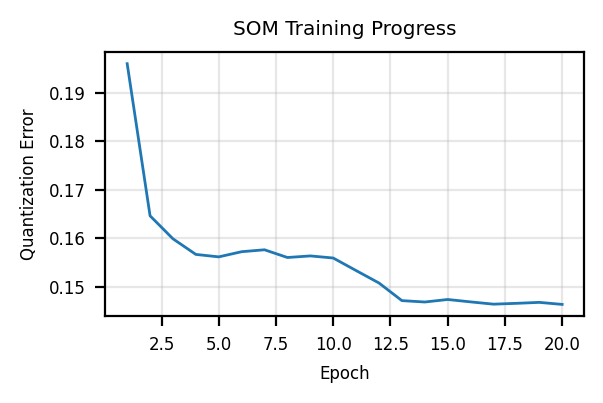

In [ ]:
plt.figure(figsize=(3, 2))
plt.plot(range(1, n_epochs+1), qe_errs, lw=1)
plt.grid(True, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Quantization Error')
plt.title('SOM Training Progress')
plt.tight_layout()

### II.5 Topographic Error (TE)

**AI Prompt**


Let me give you my understanding of the Topographic Error metric. For each sample,
- we take is best matching unit (bmu1) and its second best matching unit (bmu2)
- if bmu2 is not adjacent (left, right, bottom, up, bottom right, ...) to bmu1 we count it as one error

TE is simply the percentage of the number of such errors over the total number of training samples. Is my understanding correct?

:::{.callout-tip}

**AI Response** 


Yes, your understanding of Topographic Error is exactly right! Let's break down the key points:

1. For each input sample:
   - Find BMU (1st best)
   - Find second BMU (2nd best)
   - Check if they're adjacent using our neighbor definition
   - Count as error if not adjacent

2. Final TE = (number of errors) / (total samples)

We already have most pieces:
- Distance calculation
- BMU finding
- Neighbor definition (from U-Matrix implementation)

Would you like to create a function to:
1. Find the second-best BMU (we'll need to modify our existing BMU code), or
2. Check if two positions are adjacent (we can use our `nbr_offsets` from earlier)

Which part would you like to tackle first?
:::

**AI Prompt**


How could I find the index of the two closest units/element in a SOM/array? I could possibly identify the bmu using the function already available, reassign the value of this bmu to `np.inf` on a copy of the som and take the bmu again to get the second one. What do you think? It is likely we can do it in a more straightforward way, don't you think?

:::{.callout-tip}

**AI Response** 


Ah yes, there's a more elegant way! We can use `np.argpartition()` which is specifically designed to find the k smallest (or largest) elements in an array. It's more efficient than your suggested approach since:

1. It doesn't require making a copy
2. It only partially sorts the array (just enough to find the k smallest values)
3. It's a single operation

Would you like to explore how to use `np.argpartition()` to find the indices of the two smallest distances? We can then use `np.unravel_index()` like we did before to convert these to grid coordinates.

Would you like to try this approach?
:::

**AI Prompt**


Can you explain how to retrieve the two smallest value in a 2D numpy array using np.argpartition?

:::{.callout-tip}

**AI Response** 


Let's break this down with a simple example:

```python
# Create a sample 2D array
arr = np.array([[5, 2, 3],
                [1, 7, 4],
                [6, 8, 9]])

# Get indices of 2 smallest values using np.argpartition
# We first flatten the array, then find indices of 2 smallest values
flat_indices = np.argpartition(arr.flatten(), 2)[:2]

# Convert flat indices back to 2D coordinates using unravel_index
indices_2d = np.unravel_index(flat_indices, arr.shape)
```

Would you like to try this with a small example to see how it works? We can then adapt it for our SOM distances.
:::

In [ ]:
# Create a sample 2D array
arr = np.array([[5, 2, 3],
                [1, 7, 4],
                [6, 8, 9]])

# Get indices of 2 smallest values using np.argpartition
# We first flatten the array, then find indices of 2 smallest values
flat_indices = np.argpartition(arr.flatten(), 2)[:2]
print(f'flat indices: {flat_indices}')

# Convert flat indices back to 2D coordinates using unravel_index
rows_idx, cols_idx = np.unravel_index(flat_indices, arr.shape)
list(zip(rows_idx, cols_idx))

flat indices: [3 1]


[(1, 0), (0, 1)]

In [ ]:
x = np.array([
    [[1], [3], [1]],
    [[11], [4], [2]],
    [[7], [8], [5]]])

dist_fn(np.array(3.9), x)

array([[2.9, 0.9, 2.9],
       [7.1, 0.1, 1.9],
       [3.1, 4.1, 1.1]])

In [ ]:
arr = dist_fn(np.array(3.9), x)
flat_indices = np.argpartition(arr.flatten(), 2)[:2]
rows_idx, cols_idx = np.unravel_index(flat_indices, arr.shape)
list(zip(rows_idx, cols_idx))

[(1, 1), (0, 1)]

Actually by checking directly the difference of rows and cols indices returned for the two closest elements we can already check if they are adjacent or not (if any of the difference of the two > 1).

In [ ]:
arr = dist_fn(np.array(3.9), x)
flat_indices = np.argpartition(arr.flatten(), 2)[:2]
indices = np.unravel_index(flat_indices, arr.shape)
indices

(array([1, 0]), array([1, 1]))

In [ ]:
any([np.abs(x-y)> 1 for x,y in indices])

False

Ok I think we have everything to implement the TE error.

In [ ]:
n_errs = 0
for x in X:
    arr = dist_fn(x, ws)
    flat_indices = np.argpartition(arr.flatten(), 2)[:2]
    indices = np.unravel_index(flat_indices, arr.shape)
    if any([np.abs(x-y)> 1 for x,y in indices]): n_errs+=1
n_errs

38

In [ ]:
def te_err(X, ws, dist_fn=dist_fn):
    n_errs = 0
    for x in X:
        arr = dist_fn(x, ws)
        flat_indices = np.argpartition(arr.flatten(), 2)[:2]
        indices = np.unravel_index(flat_indices, arr.shape)
        if any([np.abs(x-y)> 1 for x,y in indices]): n_errs+=1
    return 100*n_errs / len(X)

te_err(X, ws)

3.8

In [ ]:
n_samples = len(X)
grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
ws = np.random.randn(*grid_sz, X.shape[-1])

te_errs = []
n_epochs = 20
for epoch in range(n_epochs):
    X_ = np.random.permutation(X)
    for x in X:
        kernelf_fn = partial(gaussian_fn, sigma=1)
        ws = update(x, ws, dist_fn, kernel_fn, lr=0.1)
    te_errs.append(te_err(X, ws))

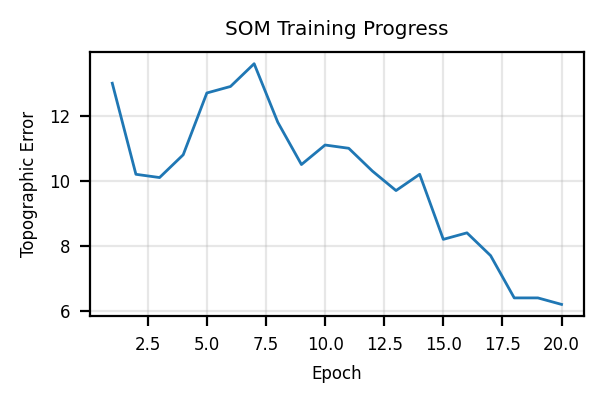

In [ ]:
plt.figure(figsize=(3, 2))
plt.plot(range(1, n_epochs+1), te_errs, lw=1)
plt.grid(True, alpha=0.3)
plt.xlabel('Epoch')
plt.ylabel('Topographic Error')
plt.title('SOM Training Progress')
plt.tight_layout()

### II.6 LR and σ schedulers

**AI Prompt**

We want a scheduler that given current step (epoch?) will decay both the learning rate and sigma for instance. Now I have a question. What do you think, should I make it flexible enough so that we could potentially decay them even before the end of an epoch?

:::{.callout-tip}

**AI Response** 


That's a great question! Yes, making the scheduler flexible enough to handle both epoch-level and sample-level updates would be more versatile, because:

1. Different SOM implementations might need:
   - Epoch-level decay (simpler, more common)
   - Mini-batch decay
   - Sample-level decay (finest granularity)

2. Some papers suggest that fine-grained decay can be beneficial for:
   - Better convergence
   - More precise neighborhood adaptation
   - Handling streaming data

Would you like to design a scheduler interface that can handle both cases? We could:
1. Make it step-based rather than epoch-based
2. Let the user define what constitutes a "step"
3. Allow different decay functions

Would you like to explore any of these aspects first?


**AI Prompt**


Letting users define what constitues a "step" (e.g every n samples) sounds more flexible I think. Let's implement it.

:::{.callout-tip}

**AI Response** 


Good choice! Let's design a flexible scheduler. We'll need to:

1. Track:
   - Current step number
   - Initial value (lr or sigma)
   - Decay function

2. Allow users to:
   - Define custom decay functions
   - Specify when to step (sample, batch, epoch)

Would you like to start with implementing a basic scheduler class or first explore some common decay functions? 

For decay functions, we could implement common ones like:
- Linear decay
- Exponential decay
- Power decay (polynomial)

Which would you prefer to tackle first?
:::

**AI Prompt**


I step_sz means the every number of samples requires before updating a value. How to name the total number of samples*number of epochs where we reach the end of the decay?

:::{.callout-tip}

**AI Response** 


In scheduling contexts, this is often called the "total_steps" or "max_steps" - it represents the total number of update opportunities over the entire training process.

So if we have:
- n_samples = 1000
- n_epochs = 20
- step_size = 10 (update every 10 samples)

Then:
```python
total_steps = (n_samples * n_epochs) // step_size
```

Would you like to use one of these names, or do you have another preference for what to call this parameter? We could also call it "decay_steps" or "schedule_length" if you think that would be clearer.
:::


In [ ]:
3000//step_sz

0

In [ ]:
def exp_sched(start_val, end_val, i, n_steps):
    decay = -np.log(end_val/start_val)/n_steps
    return start_val * np.exp(-decay * i)

step_sz = 5000
n_samples = 10_000 
n_epochs = 10
n_steps = n_epochs*n_samples//step_sz
start_v, end_v = 10, 1

step_idx = 0
v = start_v
vs = []
steps = []
for i in range(n_epochs):
    for j in range(n_samples):
        total_samples = i*n_samples + j
        if total_samples % step_sz == 0:
            v = exp_sched(start_v, end_v, step_idx, n_steps)
            vs.append(v)
            steps.append(step_idx)
            step_idx+=1

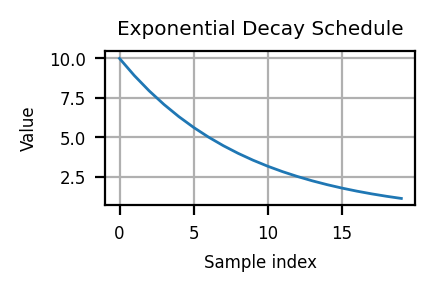

In [ ]:
plt.figure(figsize=(2, 1))
plt.plot(steps, vs, lw=1)
plt.grid(True)
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.title('Exponential Decay Schedule')
plt.show()

In [ ]:
from fastcore.all import *

In [ ]:
class Scheduler:
    def __init__(self, start_val, end_val, step_size, 
                 n_samples, n_epochs, decay_fn=exp_sched):
        store_attr()
        self.current_step = 0
        self.current_value = start_val
        self.total_steps = (n_samples * n_epochs) // step_size
    
    def step(self, total_samples):
        if total_samples % self.step_size == 0:
            self.current_value = self.decay_fn(
                self.start_val, self.end_val, 
                self.current_step, self.total_steps
            )
            self.current_step += 1
        return self.current_value

### II.7 Advanced training loop with schedulers

In [ ]:
n_samples = len(X)
grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
ws = np.random.randn(*grid_sz, X.shape[-1])

step_size=100
lr_scheduler = Scheduler(start_val=1, end_val=0.01, step_size=step_size, 
                        n_samples=len(X), n_epochs=n_epochs)
sigma_scheduler = Scheduler(start_val=6.0, end_val=1., step_size=step_size, 
                          n_samples=len(X), n_epochs=n_epochs)

n_epochs = 20
# Training loop
for epoch in range(n_epochs):
    X_ = np.random.permutation(X)
    for i, x in enumerate(X_):
        total_samples = epoch * len(X) + i
        
        # Get current lr and sigma values
        lr = lr_scheduler.step(total_samples)
        sigma = sigma_scheduler.step(total_samples)
        
        # Update weights using current lr and sigma
        kernel_fn = partial(gaussian_fn, sigma=sigma)
        ws = update(x, ws, dist_fn, kernel_fn, lr=lr)

In [ ]:
def fit(X, ws, lr_scheduler, sigma_scheduler, n_epochs=20, shuffle=True):
    qe_errs = []
    te_errs = []
    for epoch in range(n_epochs):
        X_ = np.random.permutation(X) if shuffle else X.copy()
        for i, x in enumerate(X_):
            total_samples = epoch * len(X) + i
            lr = lr_scheduler.step(total_samples)
            sigma = sigma_scheduler.step(total_samples)
            kernel_fn = partial(gaussian_fn, sigma=sigma)
            ws = update(x, ws, dist_fn, kernel_fn, lr=lr)
        qe, te = qe_err(X,ws), te_err(X,ws)
        qe_errs.append(qe)
        te_errs.append(te)
        print(f'Epoch: {epoch+1} | QE: {qe_err(X,ws)}, TE: {te_err(X,ws)}')
    return ws, qe_errs, te_errs

In [ ]:
n_samples = len(X)
grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
ws = np.random.randn(*grid_sz, X.shape[-1])

step_size=100
lr_scheduler = Scheduler(start_val=1, end_val=0.01, step_size=step_size, 
                        n_samples=len(X), n_epochs=n_epochs)
sigma_scheduler = Scheduler(start_val=6.0, end_val=1., step_size=step_size, 
                          n_samples=len(X), n_epochs=n_epochs)

ws, qe_errs, te_errs = fit(X, ws, lr_scheduler, sigma_scheduler, n_epochs=20)

Epoch: 1 | QE: 0.7361545362516652, TE: 0.1
Epoch: 2 | QE: 0.5148950211961353, TE: 1.4
Epoch: 3 | QE: 0.4161479264406785, TE: 2.5
Epoch: 4 | QE: 0.3261032895452769, TE: 0.3
Epoch: 5 | QE: 0.4344722303659532, TE: 0.6
Epoch: 6 | QE: 0.4660129942532872, TE: 0.1
Epoch: 7 | QE: 0.3492315992581065, TE: 0.6
Epoch: 8 | QE: 0.30374238796782127, TE: 1.3
Epoch: 9 | QE: 0.31955520142421034, TE: 0.4
Epoch: 10 | QE: 0.26528420358326743, TE: 0.3
Epoch: 11 | QE: 0.23678200850531003, TE: 0.8
Epoch: 12 | QE: 0.21944164206845745, TE: 0.6
Epoch: 13 | QE: 0.20784349249994324, TE: 0.5
Epoch: 14 | QE: 0.20141528673718959, TE: 1.2
Epoch: 15 | QE: 0.18861138082733617, TE: 0.9
Epoch: 16 | QE: 0.17765457467386436, TE: 1.5
Epoch: 17 | QE: 0.17077969894350056, TE: 1.1
Epoch: 18 | QE: 0.16341102935415364, TE: 1.5
Epoch: 19 | QE: 0.15816356896585257, TE: 1.3
Epoch: 20 | QE: 0.154156360812519, TE: 0.7


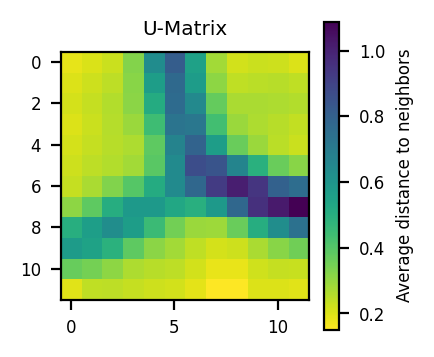

In [ ]:
plot_umatrix(ws)

**AI Prompt**


I am wondering how to best choose the initial and end learning rate and sigma. Is there any standard methodology other than grid search? Any thumb of rules I must be aware of?

:::{.callout-tip}

**AI Response** 


Yes, there are some common guidelines for SOM hyperparameters:

1. Learning Rate (lr):
   - Start: Usually between 0.1 and 1.0
   - End: Small but non-zero (0.01 or even smaller)
   - Rule of thumb: Higher initial lr for larger datasets/maps

2. Sigma (neighborhood radius):
   - Start: Usually max(grid_width, grid_height)/2
   - End: Should cover about one unit (0.5-1.0)
   - Rule of thumb: Larger initial sigma helps global ordering

3. General principles:
   - Training has two phases:
     1. Ordering phase: High lr and sigma for global organization
     2. Fine-tuning phase: Low lr and sigma for local adjustments
   - Training length should be at least 500 times number of nodes

Would you like to try adjusting your parameters based on these guidelines?
:::


### II.8 Revised plan

**AI Prompt**


No that's ok for now, thanks a lot! Now I think we need once more time to revise the plan as we are making very good progress and focus on the remaining steps. As a reminder, here below the previous plan:
You make excellent points! Yes, we should revise the plan to better integrate visualization and metrics with the training loop, since they're crucial for understanding how the SOM evolves. Here's a suggested revision:

1. Core SOM Components (DONE)
   - ✓ Initialize weight grid
   - ✓ Distance metrics
   - ✓ BMU function
   - ✓ Neighborhood function
   - ✓ Weight update rule

2. Extended Training Components
   - Training loop structure - DONE
   - U-Matrix visualization (moved up from 4) - DONE
   - Basic quality metrics (moved up from 3) - DONE
   - Learning rate scheduler - DONE
   - Radius scheduler - DONE
   - Training progress visualization - DONE 

3. Additional Quality Metrics
   - Quantization error - DONE
   - Topographic error - DONE
   - Custom metrics interface

4. Additional Visualizations
   - Component planes
   - Custom visualization options

5. Refactoring
   - Class structure
   - Flexible interfaces
   - Documentation

I have further specified which steps were already completed! You evoked additional visualization techniques (on top of the u-matrix) and possible additional metrics. Last the refactoring and documentation phases remains highligh important as final steps. However there is one important aspects we have not addressed that we should address next which is the initialization of the SOM/weights. Now we are doing it randomly, I think we can use PCA also. I would be interested to understand it in further details and implement it. 

Can you advise and propose an update plan? Important: Consider the numbering of each steps already used so that the new plan can be appended to it consistently.

:::{.callout-tip}

**AI Response** 


Yes, you're right! The PCA initialization is an important addition. Here's the updated plan, maintaining consistent numbering and adding the initialization as step 6 before refactoring:

III. Weights Initialization Methods
   - Random (current - DONE)
   - PCA-based initialization
   - Comparison of initialization impacts

IV. Additional Quality Metrics & Visualization
   - Component planes
   - Additional custom metrics interface
   - Custom visualization options

V. Refactoring & Documentation
   - Class structure
   - Flexible interfaces
   - Comprehensive documentation
   - Usage examples

Would you like to start exploring the PCA initialization approach? I can explain how PCA can help initialize the SOM weights more effectively than random initialization.
:::

## III. WEIGHTS INITIALIZATION METHODS

**AI Prompt**


Can you explain what's the idea of using PCA to initialize SOM weights?

:::{.callout-tip}

**AI Response** 


The idea behind PCA initialization for SOM weights is quite clever:

1. Main concept:
   - Instead of random initialization, we want initial weights that already reflect the data's structure
   - PCA finds the principal directions of variation in your data
   - We can use these directions to create a more informed initial grid

2. The process typically works by:
   - Finding the two largest principal components of your data
   - Using these to create a linear interpolation grid
   - This grid becomes your initial weights

3. Benefits:
   - Faster convergence (weights start closer to final configuration)
   - More stable training
   - Better preservation of data topology

Would you like me to explain more about how this works in practice, or would you prefer to start implementing it?
:::

**AI Prompt**


Yes I know PCA but your statement "Using these to create a linear interpolation grid" is a bit unclear to me. Please further elaborate.

:::{.callout-tip}

**AI Response** 


Ah, let me clarify the linear interpolation part:

Let's say we have a 4x4 SOM grid and our data is 3-dimensional. After PCA:

1. We get two principal components (PC1 and PC2)
   - These define a 2D plane where data varies most

2. The "linear interpolation grid" means:
   - Along rows: We interpolate values from -1 to 1 using PC1 (4 points)
   - Along columns: We interpolate values from -1 to 1 using PC2 (4 points)
   - Each grid point becomes: (α*PC1 + β*PC2)
   - Where α and β are the interpolated values

So each weight vector is a linear combination of PC1 and PC2, creating a regular grid that spans the main directions of variation in your data.

Would you like to see this process with a small example using your dataset?
:::

**AI Prompt**


Thanks it's a bit clearer. Let me try to reformulate it, in the context of a highly dimensional dataset (which is the primary target of SOM), we take the two largest principal components (PCs) and generate the initial weights of the grid in the span of those two PCs.

I have two remarks:
- in the situation where our input dataset is 2D, there would be no added value as we could have equally taken initial weights in the span of the initial basis (randomly)
- don't you think that would be also important to consider the eigen values (% of variance explained by each PCs) to generate those initial SOM weights? Do you see my point?

What do you think?

:::{.callout-tip}

**AI Response** 


Excellent observations! Let me address both points:

1. 2D data case:
   - ✓ You're absolutely right! PCA initialization would be less beneficial
   - The benefit really shows in higher dimensions where random initialization might miss important data structure

2. Eigenvalues consideration:
   - ✓ Very insightful point! Yes, the variance explained by each PC is important
   - We could use the eigenvalues to:
     * Scale the grid points according to the relative importance of each PC
     * Make the grid more stretched along PC1 if it explains much more variance than PC2
     * This would better reflect the actual data distribution

Would you like to modify the initialization approach to incorporate the eigenvalues? We could scale the α and β coefficients by the square root of their respective eigenvalues to reflect the relative importance of each direction.
:::

**AI Prompt**


Great!Let's implement it but let me try first.

:::{.callout-tip}

**AI Response** 


Perfect! Go ahead and try implementing it yourself. If you get stuck or want to discuss your implementation, I'm here to help. 

Remember you'll need to:
1. Perform PCA on your data
2. Get the first two PCs and their eigenvalues
3. Create the interpolation grid with eigenvalue scaling

Let me know when you want to discuss your implementation or if you need any clarification!
:::

To assess the added value of PCA initialization we should use a higher dimentionsal toy dataset. We choose the MNIST dataset for that purpose as provided by scikitlearn.

In [ ]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True)
X.shape, y.shape

((1797, 64), (1797,))

In [ ]:
# Using column-wise centering to keep pixels correlation
X_norm = (X - np.mean(X, axis=-1, keepdims=True))/X.max()
X_norm[:3,:3]

array([[-0.28710938, -0.28710938,  0.02539062],
       [-0.30566406, -0.30566406, -0.30566406],
       [-0.3359375 , -0.3359375 , -0.3359375 ]])

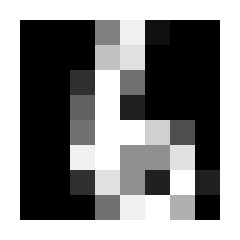

In [ ]:
plt.figure(figsize=(1, 1))  
plt.axis('off')
plt.imshow(X_norm[16].reshape(8,8), cmap='gray')
plt.tight_layout(pad=0)
plt.show()

## III.1 Random initialization

In [ ]:
#n_samples = len(X)
#grid_sz = (n_nodes(n_samples),n_nodes(n_samples))
grid_sz = (20,20)
ws = np.random.randn(*grid_sz, X.shape[-1])

step_size=200
lr_scheduler = Scheduler(start_val=1, end_val=0.01, step_size=step_size, 
                         n_samples=len(X), n_epochs=n_epochs)
sigma_scheduler = Scheduler(start_val=10.0, end_val=1., step_size=step_size, 
                            n_samples=len(X), n_epochs=n_epochs)

ws, qe_errs, te_errs = fit(X_norm, ws, lr_scheduler, sigma_scheduler, n_epochs=20)

Epoch: 1 | QE: 2.0704569004526077, TE: 1.613800779076238
Epoch: 2 | QE: 1.9993114714766416, TE: 2.782415136338342
Epoch: 3 | QE: 1.861177046446639, TE: 0.8903728436282693
Epoch: 4 | QE: 1.9219833266979651, TE: 2.1702838063439067
Epoch: 5 | QE: 1.8149792250549173, TE: 1.947690595436839
Epoch: 6 | QE: 1.7232480060982525, TE: 0.5564830272676683
Epoch: 7 | QE: 1.6416867945969185, TE: 0.8347245409015025
Epoch: 8 | QE: 1.6012357873004686, TE: 0.8347245409015025
Epoch: 9 | QE: 1.525608040533907, TE: 0.38953811908736785
Epoch: 10 | QE: 1.4982022948153044, TE: 0.11129660545353366
Epoch: 11 | QE: 1.437747418705183, TE: 0.7790762381747357
Epoch: 12 | QE: 1.3905844080513237, TE: 0.6121313299944352
Epoch: 13 | QE: 1.3560227127148223, TE: 0.667779632721202
Epoch: 14 | QE: 1.3173744703746464, TE: 0.8347245409015025
Epoch: 15 | QE: 1.2798663316734378, TE: 0.7234279354479688
Epoch: 16 | QE: 1.2483547543469942, TE: 0.5008347245409015
Epoch: 17 | QE: 1.219034936826061, TE: 0.44518642181413465
Epoch: 18 |

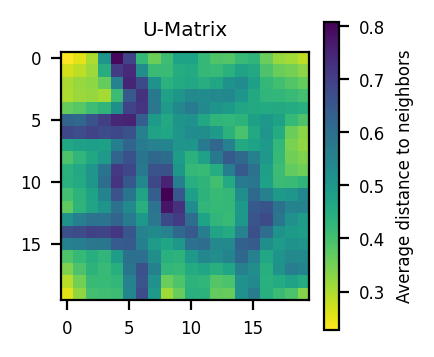

In [ ]:
plot_umatrix(ws)

### III.2 PCA initialization

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_norm)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.15122797 0.13826949]
[35.43643386 33.88419201]


In [ ]:
pca.components_.shape

(2, 64)

In [ ]:
np.linspace(-1,1,num=10)

array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
        0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ])

In [ ]:
# -1*e1*v1 + -1*e2*v2
# -0.9*e1*v1 + -0.9*e2*v2

**AI Prompt**


Once I have the 2 highest eigen values and vectors, how do I create a `nxn` matrix to be used as SOM based on this?

:::{.callout-tip}

**AI Response** 


For a n×n SOM grid, here's how to create the PCA-initialized weights:

1. Create two sets of coefficients:
```python
alpha = np.linspace(-1, 1, n)  # for PC1
beta = np.linspace(-1, 1, n)   # for PC2
```

1. Scale them by square root of eigenvalues:
```python
alpha *= np.sqrt(pca.explained_variance_[0])
beta *= np.sqrt(pca.explained_variance_[1])
```

1. Create the grid using outer products:
```python
# Create meshgrid
alpha_grid, beta_grid = np.meshgrid(alpha, beta)

# Initialize weights array
weights = np.zeros((n, n, X.shape[1]))  # shape: (n, n, 64) for MNIST

# Each weight is a linear combination of PC1 and PC2
weights = (alpha_grid[..., np.newaxis] * pca.components_[0] + 
          beta_grid[..., np.newaxis] * pca.components_[1])
```

Would you like to try implementing this approach?
:::

In [ ]:
grid_sz = (20,20)
n = grid_sz[0]
alpha = np.linspace(-1, 1, n)  # for PC1
beta = np.linspace(-1, 1, n)   # for PC2

In [ ]:
alpha *= np.sqrt(pca.explained_variance_[0])
beta *= np.sqrt(pca.explained_variance_[1])

In [ ]:
alpha_grid, beta_grid = np.meshgrid(alpha, beta)

In [ ]:
ws = np.zeros((n, n, X.shape[1]))

In [ ]:
ws = (alpha_grid[..., np.newaxis] * pca.components_[0] + 
          beta_grid[..., np.newaxis] * pca.components_[1])
ws.shape

(20, 20, 64)

In [ ]:
step_size=200
lr_scheduler = Scheduler(start_val=1, end_val=0.01, step_size=step_size, 
                         n_samples=len(X), n_epochs=n_epochs)
sigma_scheduler = Scheduler(start_val=10.0, end_val=1., step_size=step_size, 
                            n_samples=len(X), n_epochs=n_epochs)

ws, qe_errs, te_errs = fit(X_norm, ws, lr_scheduler, sigma_scheduler, n_epochs=20)

Epoch: 1 | QE: 2.021117062983796, TE: 2.949360044518642
Epoch: 2 | QE: 2.0374532407086186, TE: 3.728436282693378
Epoch: 3 | QE: 1.9381056000802876, TE: 1.1686143572621035
Epoch: 4 | QE: 1.8750135481900163, TE: 3.394546466332777
Epoch: 5 | QE: 1.7731177749486253, TE: 0.9460211463550362
Epoch: 6 | QE: 1.7381528690875534, TE: 1.1129660545353366
Epoch: 7 | QE: 1.6576526895942232, TE: 1.335559265442404
Epoch: 8 | QE: 1.585401407283374, TE: 1.279910962715637
Epoch: 9 | QE: 1.564939121993558, TE: 0.9460211463550362
Epoch: 10 | QE: 1.4887308931209031, TE: 0.8347245409015025
Epoch: 11 | QE: 1.4567525145876061, TE: 0.8347245409015025
Epoch: 12 | QE: 1.3981773691503705, TE: 0.667779632721202
Epoch: 13 | QE: 1.3556213938081516, TE: 0.667779632721202
Epoch: 14 | QE: 1.317842103259422, TE: 0.7790762381747357
Epoch: 15 | QE: 1.2812507568473976, TE: 0.5008347245409015
Epoch: 16 | QE: 1.2470507719706745, TE: 0.5564830272676683
Epoch: 17 | QE: 1.2189855689098217, TE: 0.5564830272676683
Epoch: 18 | QE: 1

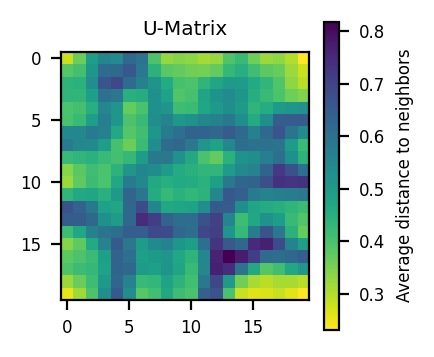

In [ ]:
plot_umatrix(ws)

**AI Prompt**


The effect of PCA initialization is not probative above. How could I see the added value?

:::{.callout-tip}

**AI Response** 


To better demonstrate the value of PCA initialization, we could:

1. Compare convergence speed:
   - Run both initializations multiple times
   - Plot learning curves (QE vs epochs) on the same graph
   - Start with fewer epochs to see early convergence

2. Use a more complex dataset:
   - MNIST digits at higher resolution
   - Or a dataset with more pronounced principal components
   - Currently we're using 8x8 digits which might be too simple

3. Visualize initial state:
   - Show U-Matrix right after initialization (before training)
   - Compare random vs PCA initialization structures

4. Adjust hyperparameters:
   - Different learning rates
   - Different grid sizes
   - Different sigma values

Which approach would you like to try first to better demonstrate the difference between random and PCA initialization?
:::

**AI Prompt**

Thanks, very useful! That's fine for now I will perform this thorough assessment later.

:::{.callout-tip}

**AI Response** 


Alright! We've covered PCA initialization and have some good ideas for evaluating its effectiveness later. 

Would you like to move on to the next part of our plan? We could look at:
1. Component planes visualization
2. Additional quality metrics
3. Start the refactoring phase

Which would you prefer to tackle next?
:::

## IV. ADDITIONAL VISUALIZATIONS

**AI Prompt**

Explain me the concept of "Component planes visualization" in the contexte of the MNIST dataset for instance.

:::{.callout-tip}

**AI Response** 


In the context of MNIST, component planes visualization is particularly interesting:

1. Basic concept:
   - Each weight vector (node) has 64 components (8x8 pixels)
   - A component plane shows how ONE of these 64 components varies across the SOM grid
   - We get 64 different "heatmaps", one for each pixel position

2. For MNIST specifically:
   - Each component plane shows how a specific pixel varies across the map
   - Bright areas = high pixel values in that position
   - Dark areas = low pixel values in that position
   - This reveals which regions of the SOM activate specific parts of the digits

3. Interpretation:
   - Similar patterns across component planes suggest correlated pixels
   - Some planes might show clear structures (e.g., strong activation in middle pixels for digit "1")
   - Helps understand how the SOM has organized digit features

Would you like to visualize some component planes for our trained MNIST SOM to see this in practice?
:::

**AI Prompt**


Ok I see, I will implement it later, let's focus on the refactoring and the documentation now.

:::{.callout-tip}

**AI Response** 


Sure! For refactoring, we should create a well-structured class that encapsulates all the functionality we've built. Here's what we could consider:

1. Core SOM Class structure:
   - Initialization (random/PCA)
   - Training methods
   - Visualization methods
   - Quality metrics
   - Flexible interfaces for schedulers

2. Documentation needs:
   - Clear docstrings
   - Usage examples
   - Parameter descriptions
   - References to literature

Would you like to start with:
1. Designing the class interface
2. Writing the documentation structure
3. Organizing the methods we've created

Which aspect would you prefer to tackle first?
:::


## V. REFACTORING

**AI Prompt**

Please design a class interface embedding all components implemented above. 
Make sure to:
- use nbdev-like documentation and docstrings
- use fastai coding style

:::{.callout-tip}

I'll design a class interface following nbdev and fastai style. Let's start with the core class structure:

```python
class SOM:
    def __init__(self, grid_sz:tuple, # Size of the SOM grid (rows, cols)
                 input_dim:int,        # Dimension of input data
                 init:str='random',    # Initialization method: 'random' or 'pca'
                 dist_fn=np.linalg.norm # Distance metric function
                ):
        "Initialize a Self-Organizing Map with given grid size and input dimension"
        
    def fit(self, X:np.ndarray,           # Training data
            n_epochs:int=20,              # Number of training epochs
            lr_scheduler:Scheduler=None,   # Learning rate scheduler
            sigma_scheduler:Scheduler=None, # Neighborhood radius scheduler
            shuffle:bool=True,             # Shuffle data each epoch
            verbose:bool=True              # Print training progress
           )->tuple:                       # Returns (weights, qe_errors, te_errors)
        "Train the SOM on input data X"
        
    def transform(self, X:np.ndarray # Input data to transform
                )->np.ndarray:       # Returns BMU coordinates for each input
        "Find Best Matching Unit (BMU) for each input vector"
        
    @property
    def umatrix(self)->np.ndarray:  # Returns U-Matrix of current weights
        "Calculate and return the U-Matrix"
        
    def quantization_error(self, X:np.ndarray # Input data
                         )->float:            # Returns QE value
        "Calculate quantization error for input data"
        
    def topographic_error(self, X:np.ndarray # Input data
                        )->float:            # Returns TE value
        "Calculate topographic error for input data"
```

Would you like me to:
1. Add more methods
2. Elaborate on any particular method
3. Add more documentation details
4. Show how the existing functions would fit into this structure

What would be most helpful?
:::

**AI Prompt**

The interface looks fine, please feed it with the implementations

:::{.callout-tip}

I'll help you implement the class step by step. Let's start with the core structure and basic methods:

```python
class SOM:
    def __init__(self, grid_sz:tuple, input_dim:int, init:str='random', dist_fn=np.linalg.norm):
        "Initialize a Self-Organizing Map with given grid size and input dimension"
        store_attr()
        self.weights = self._initialize_weights(init)
        
    def _initialize_weights(self, method:str)->np.ndarray:
        "Initialize weights using either random or PCA initialization"
        if method == 'random':
            return np.random.randn(*self.grid_sz, self.input_dim)
        elif method == 'pca':
            # We'll implement PCA initialization
            raise NotImplementedError("PCA initialization to be implemented")
```

Would you like me to continue with implementing more methods? We can do this incrementally, testing each part as we go. Which method would you like to implement next?

1. PCA initialization
2. Core training loop (fit)
3. Transform method
4. Error metrics

Let me know which you'd prefer to tackle first!
:::

**AI Prompt**

Next implement, PCA initialization.

:::{.callout-tip}

I'll add the PCA initialization to our SOM class. We'll need to modify the `_initialize_weights` method and add a helper method for PCA:

```python
from sklearn.decomposition import PCA

class SOM:
    def __init__(self, grid_sz:tuple, input_dim:int, init:str='random', dist_fn=np.linalg.norm):
        "Initialize a Self-Organizing Map with given grid size and input dimension"
        store_attr()
        self.weights = None  # Will be initialized when fitting
        
    def _initialize_weights_pca(self, X:np.ndarray)->np.ndarray:
        "Initialize weights using PCA of the input data"
        pca = PCA(n_components=2)
        pca.fit(X)
        
        # Create grid coordinates and scale by eigenvalues
        n = self.grid_sz[0]
        alpha = np.linspace(-1, 1, n) * np.sqrt(pca.explained_variance_[0])
        beta = np.linspace(-1, 1, n) * np.sqrt(pca.explained_variance_[1])
        
        # Create the grid
        alpha_grid, beta_grid = np.meshgrid(alpha, beta)
        
        # Initialize weights as linear combination of first two PCs
        return (alpha_grid[..., np.newaxis] * pca.components_[0] + 
                beta_grid[..., np.newaxis] * pca.components_[1])
    
    def _initialize_weights(self, X:np.ndarray=None, method:str='random')->np.ndarray:
        "Initialize weights using either random or PCA initialization"
        if method == 'random':
            return np.random.randn(*self.grid_sz, self.input_dim)
        elif method == 'pca':
            if X is None: 
                raise ValueError("Data matrix X required for PCA initialization")
            return self._initialize_weights_pca(X)
```

Note that we've modified the initialization to:
1. Accept the input data X when needed for PCA
2. Move PCA logic to a separate method
3. Make weights initialization defer until we have data

Would you like to implement the next component? We could tackle:
1. Core training loop (fit)
2. Transform method
3. Error metrics

Which would you prefer?
:::

**AI Prompt**

Implement the core training loop

:::{.callout-tip}

I'll implement the core training loop (fit method) and its supporting functions. We'll need to include the neighborhood and update logic we developed earlier:

```python
class SOM:
    # ... (previous methods remain the same)
    
    def _find_bmu(self, x:np.ndarray)->tuple:
        "Find coordinates of Best Matching Unit for input x"
        distances = self.dist_fn(x, self.weights)
        return np.unravel_index(np.argmin(distances), self.grid_sz)
    
    def _grid_distances(self, bmu_pos:tuple)->np.ndarray:
        "Calculate grid distances from BMU position"
        rows_idx, cols_idx = np.ogrid[0:self.grid_sz[0], 0:self.grid_sz[1]]
        return (bmu_pos[0] - rows_idx)**2 + (bmu_pos[1] - cols_idx)**2
    
    def _neighborhood_function(self, grid_dist:np.ndarray, sigma:float)->np.ndarray:
        "Calculate neighborhood function values"
        return np.exp(-grid_dist/(2*sigma**2))
    
    def _update_weights(self, x:np.ndarray, learning_rate:float, sigma:float):
        "Update weights for a single input vector"
        bmu_pos = self._find_bmu(x)
        grid_dist = self._grid_distances(bmu_pos)
        neighborhood = self._neighborhood_function(grid_dist, sigma)
        self.weights += learning_rate * neighborhood[..., np.newaxis] * (x - self.weights)
    
    def fit(self, X:np.ndarray, n_epochs:int=20, 
            lr_scheduler:Scheduler=None, sigma_scheduler:Scheduler=None,
            shuffle:bool=True, verbose:bool=True)->tuple:
        "Train the SOM on input data X"
        # Initialize weights if not already done
        if self.weights is None:
            self.weights = self._initialize_weights(X, self.init)
        
        # Setup default schedulers if none provided
        if lr_scheduler is None:
            lr_scheduler = Scheduler(1.0, 0.01, 100, len(X), n_epochs)
        if sigma_scheduler is None:
            sigma_scheduler = Scheduler(max(self.grid_sz)/2, 1.0, 100, len(X), n_epochs)
        
        qe_errors, te_errors = [], []
        for epoch in range(n_epochs):
            X_ = np.random.permutation(X) if shuffle else X.copy()
            
            # Train on each input vector
            for i, x in enumerate(X_):
                total_samples = epoch * len(X) + i
                lr = lr_scheduler.step(total_samples)
                sigma = sigma_scheduler.step(total_samples)
                self._update_weights(x, lr, sigma)
            
            # Calculate errors
            qe = self.quantization_error(X)
            te = self.topographic_error(X)
            qe_errors.append(qe)
            te_errors.append(te)
            
            if verbose:
                print(f'Epoch: {epoch+1} | QE: {qe:.4f}, TE: {te:.4f}')
        
        return self.weights, qe_errors, te_errors
```

Would you like me to:
1. Add the error metrics methods next
2. Add the transform method
3. Explain any part of this implementation in more detail

Which would you prefer?
:::

**AI Prompt**

Ok, add the error metrics methods next

:::{.callout-tip}

**AI Response** 

I'll add the error metrics methods to our SOM class:

```python
class SOM:
    # ... (previous methods remain the same)
    
    def quantization_error(self, X:np.ndarray)->float:
        "Calculate average distance between each input vector and its BMU"
        return np.array([
            self.dist_fn(x, self.weights).min() 
            for x in X
        ]).mean()
    
    def topographic_error(self, X:np.ndarray)->float:
        "Calculate proportion of data vectors where 1st and 2nd BMUs are not adjacent"
        def _check_bmu_adjacency(x):
            # Get indices of two best matching units
            distances = self.dist_fn(x, self.weights)
            flat_indices = np.argpartition(distances.flatten(), 2)[:2]
            indices = np.unravel_index(flat_indices, self.grid_sz)
            # Check if any coordinate differs by more than 1
            return any(np.abs(x-y) > 1 for x,y in indices)
        
        n_errors = sum(_check_bmu_adjacency(x) for x in X)
        return 100 * n_errors / len(X)  # Return percentage
```

Would you like me to:
1. Add the transform method next
2. Add the U-Matrix visualization
3. Add component planes visualization
4. Something else?

Which would you prefer?
:::

**AI Prompt**

Add the transform method.

:::{.callout-tip}

**AI Response** 


I'll add the transform method to find BMU coordinates for new data points:

```python
class SOM:
    # ... (previous methods remain the same)
    
    def transform(self, X:np.ndarray)->np.ndarray:
        "Find Best Matching Unit (BMU) coordinates for each input vector"
        bmu_coords = np.zeros((len(X), 2), dtype=int)
        for i, x in enumerate(X):
            bmu_coords[i] = self._find_bmu(x)
        return bmu_coords
    
    def predict(self, X:np.ndarray)->np.ndarray:
        "Alias for transform method to follow sklearn convention"
        return self.transform(X)
```

I added both `transform` and `predict` methods to follow scikit-learn conventions. The `predict` method is just an alias for `transform`.

Would you like me to:
1. Add the U-Matrix visualization next
2. Add component planes visualization
3. Add any other methods?

Which would you prefer?
:::

**AI Prompt**

Now, implement the U-matrix component.

:::{.callout-tip}

**AI Response** 


I'll add the U-Matrix calculation and visualization methods:

```python
class SOM:
    # ... (previous methods remain the same)
    
    def _calculate_umatrix(self)->np.ndarray:
        "Calculate U-Matrix values for current weights"
        def _neighbor_distances(pos):
            # Offsets for 8 neighbors
            nbr_offsets = [
                (-1,-1), (-1,0), (-1,1),  # top-left, top, top-right
                (0,-1),          (0,1),   # left, right
                (1,-1),  (1,0),  (1,1)    # bottom-left, bottom, bottom-right
            ]
            
            distances = []
            weights = []
            for dr, dc in nbr_offsets:
                r, c = pos
                nbr_r, nbr_c = r+dr, c+dc
                if (nbr_r >= 0 and nbr_r < self.grid_sz[0] and 
                    nbr_c >= 0 and nbr_c < self.grid_sz[1]):
                    w = 1/np.sqrt(dr**2 + dc**2)  # weight by distance
                    weights.append(w)
                    d = self.dist_fn(self.weights[r,c] - self.weights[nbr_r,nbr_c])
                    distances.append(d)
            return np.average(distances, weights=weights)
        
        umatrix = np.zeros(self.grid_sz)
        for i, j in np.ndindex(self.grid_sz):
            umatrix[i,j] = _neighbor_distances((i,j))
        return umatrix
    
    @property
    def umatrix(self)->np.ndarray:
        "Return the U-Matrix for current weights"
        return self._calculate_umatrix()
    
    def plot_umatrix(self, figsize=(8,6), cmap='viridis_r'):
        "Plot U-Matrix visualization"
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=figsize)
        plt.imshow(self.umatrix, cmap=cmap, interpolation='nearest')
        plt.colorbar(label='Average distance to neighbors')
        plt.title('U-Matrix')
        plt.tight_layout()
        plt.show()
```

I've included:
1. Internal calculation method `_calculate_umatrix`
2. Property getter for easy access to U-Matrix
3. Plotting method with customizable parameters

Would you like me to:
1. Add component planes visualization next
2. Add any other visualization methods
3. Explain any part of the U-Matrix implementation in more detail?

Which would you prefer?
:::

### V.2 Readme.md

**AI Prompt**

Last, I'd like you to generate a `README.md` file for a package making this SOM implementation available to a wider audience (let's name this package Teuvo). I'd like it to mention the design philosophy of "SolveIt" also. Use a how to use section using the MNIST dataset for instance.

:::{.callout-tip}

**AI Response** 
I'll create a README.md for the "Teuvo" package (nice reference to Teuvo Kohonen!). I'll structure it to be clear, informative, and showcase the implementation philosophy:

```markdown
# Teuvo: A Pythonic Self-Organizing Map Implementation

A flexible, well-documented implementation of Self-Organizing Maps (SOMs) following the principles of clarity, step-by-step problem solving, and vectorized operations.

## Design Philosophy

This implementation follows the "SolveIt" approach:
- Break complex problems into manageable steps
- Prioritize clarity and understanding over premature optimization
- Document and explain each component thoroughly
- Use vectorized operations for efficiency
- Provide flexible interfaces for customization

## Installation

```bash
pip install teuvo
```

## Quick Start

```python
from teuvo import SOM
import numpy as np
from sklearn.datasets import load_digits

# Load and normalize MNIST data
X, y = load_digits(return_X_y=True)
X_norm = (X - np.mean(X, axis=-1, keepdims=True))/X.max()

# Create and train SOM
som = SOM(grid_sz=(20,20), input_dim=64, init='pca')
som.fit(X_norm, n_epochs=20)

# Visualize results
som.plot_umatrix()
```

## Features

- Multiple initialization methods:
  - Random initialization
  - PCA-based initialization (for faster convergence)
- Flexible training options:
  - Customizable learning rate schedules
  - Adjustable neighborhood functions
- Comprehensive quality metrics:
  - Quantization Error
  - Topographic Error
- Rich visualization tools:
  - U-Matrix visualization
  - Component planes (coming soon)

## Detailed Example: MNIST Digit Classification

```python
from teuvo import SOM
from teuvo.schedulers import Scheduler
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

# Load and preprocess data
X, y = load_digits(return_X_y=True)
X_norm = (X - np.mean(X, axis=-1, keepdims=True))/X.max()

# Initialize SOM
som = SOM(
    grid_sz=(20,20),
    input_dim=64,
    init='pca'  # Use PCA initialization
)

# Create custom schedulers
lr_scheduler = Scheduler(start_val=1.0, end_val=0.01, 
                       step_size=200, n_samples=len(X), n_epochs=20)
sigma_scheduler = Scheduler(start_val=10.0, end_val=1.0, 
                          step_size=200, n_samples=len(X), n_epochs=20)

# Train
weights, qe_errors, te_errors = som.fit(
    X_norm,
    n_epochs=20,
    lr_scheduler=lr_scheduler,
    sigma_scheduler=sigma_scheduler
)

# Visualize results
plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(qe_errors)
plt.title('Quantization Error')
plt.xlabel('Epoch')

plt.subplot(122)
som.plot_umatrix()

plt.tight_layout()
plt.show()
```

## Contributing

We welcome contributions! Please see our contributing guidelines for details.

## References

- Kohonen, T. (1982). Self-organized formation of topologically correct feature maps
- Kohonen, T. (2013). Essentials of the self-organizing map
- Polya, G. (1945). How to Solve It

## License

MIT

## Acknowledgments

Named in honor of Teuvo Kohonen, who introduced the Self-Organizing Map algorithm.
```

Would you like me to:
1. Add more examples
2. Expand any section
3. Add installation or dependency details
4. Add anything else?

:::

**AI Prompt**

Last request! Can you generate a TOC for the whole notebook that I will prepend for easier navigation?

**AI Response**

Here's a Table of Contents for your notebook:

```markdown
# Self-Organizing Map Implementation

## Table of Contents

I. CORE SOM COMPONENTS
   - I.1 Weight Grid Initialization
   - I.2 Distance Metrics
   - I.3 BMU (Best Matching Unit)
   - I.4 Neighborhood Function
   - I.5 Weight Update Rule

II. EXTENDED TRAINING COMPONENTS
   - II.1 A 2D Toy Dataset
   - II.2 U-Matrix
   - II.3 Naive Training Loop
   - II.4 Quantization Error (QE)
   - II.5 Topographic Error (TE)
   - II.6 LR and σ Schedulers
   - II.7 Advanced Training Loop with Schedulers
   - II.8 Revised Plan

III. WEIGHTS INITIALIZATION METHODS
   - III.1 Random Initialization
   - III.2 PCA Initialization

IV. ADDITIONAL VISUALIZATIONS

V. REFACTORING
   - V.1 Class Implementation
   - V.2 README.md

Each section follows the step-by-step development process, from basic components to the final package implementation.
```

Would you like me to:
1. Add more detail to any section
2. Reorganize any part
3. Add subsections I might have missed?